## Importing libraries and data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [3]:
# Creating path
path = r'C:\Users\Víctor A\Desktop\CAREER FOUNDRY\Immersion Achievement 6 Victor A.Gallardo\DATA'

#Importing Data
reviews = pd.read_csv(os.path.join(path, 'reviews SUMMARY.csv'), index_col = False)

## 3. Make a subset of your data set if necessary. Think about the historical domain of the series to decide if you need to (if there are irrelevant historical events in your data that would bias your analysis, for example). Also, make sure your set doesn’t include any forecasted data.

    In a markdown cell below the subset (if you make one), explain what logic you were following when selecting your data points.
    Remember that if you subset your data, you’ll need to reset the index, subset, then reset the “Date” column as your index in the new dataframe.


In [5]:
# Checking dataframe

reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385348 entries, 0 to 385347
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   listing_id  385348 non-null  int64 
 1   date        385348 non-null  object
dtypes: int64(1), object(1)
memory usage: 5.9+ MB


In [6]:
# Convert 'date' column to datetime format

reviews['date'] = pd.to_datetime(reviews['date'])

In [7]:
# Group by 'date' and count the number of reviews per day
reviews_per_day = reviews.groupby('date').size().reset_index(name='review_count')

reviews_per_day.head()

,date,review_count
0,2011-08-25,1
1,2011-09-17,1
2,2011-10-16,1
3,2011-10-25,1
4,2011-11-20,1


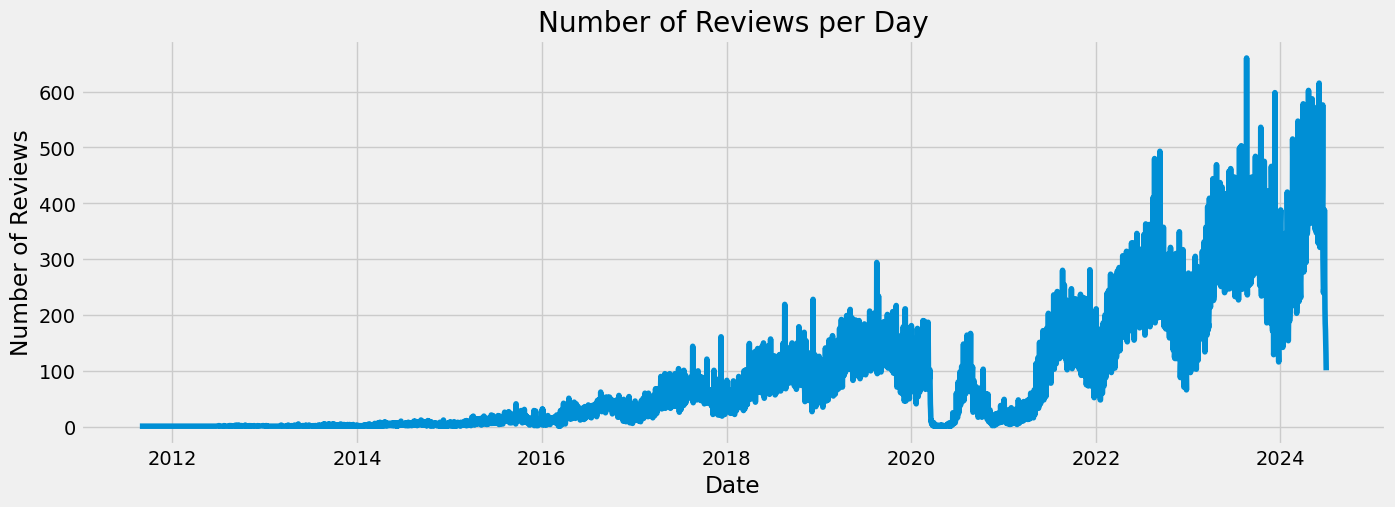

In [8]:
# Plot the data using matplotlib

plt.figure(figsize=(15, 5), dpi=100)  
plt.plot(reviews_per_day['date'], reviews_per_day['review_count'])
plt.title('Number of Reviews per Day')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

In [9]:
# Create a subset of the data from 2016 to 2023

reviews_per_day_subset = reviews_per_day.loc[(reviews_per_day['date'] >= '2016-01-01') & (reviews_per_day['date'] <= '2023-12-31')]

In [10]:
reviews_per_day_subset.head()

,date,review_count
985,2016-01-01,18
986,2016-01-02,19
987,2016-01-03,32
988,2016-01-04,3
989,2016-01-05,31


In [25]:
reviews_per_day_subset.tail()

,date,review_count
3880,2023-12-27,239
3881,2023-12-28,288
3882,2023-12-29,310
3883,2023-12-30,348
3884,2023-12-31,252


### I have decided to use the 2016-2023 span. The data before 2016 was low, so I believe that from 2016 onwards, the data would be more representative. I have not included the current year 2024 to ensure that only complete years are considered.

### Notice that there is a significant drop in the number of reviews around 2020, coinciding with the onset of the COVID-19 pandemic, which may affect the analysis.

In [22]:
# Set 'date' as the index for the subset dataframe

reviews_per_day_subset.set_index('date', inplace=True)

In [24]:
reviews_per_day_subset.head()

,review_count
date,
2016-01-01,18
2016-01-02,19
2016-01-03,32
2016-01-04,3
2016-01-05,31


## 4. Create a line chart of your data.

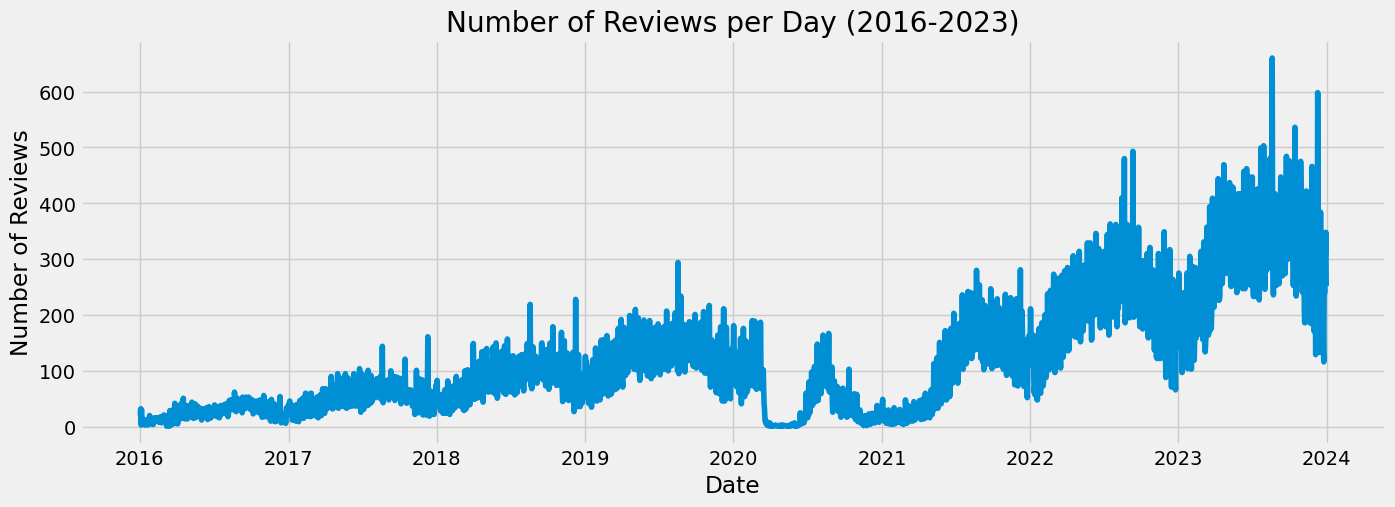

In [26]:
# Plot the data 

plt.figure(figsize=(15, 5), dpi=100)  
plt.plot(reviews_per_day_subset.index, reviews_per_day_subset['review_count'])
plt.title('Number of Reviews per Day (2016-2023)')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

## 5. Decompose the data’s components.

    Analyze the results from the plot in a markdown cell

In [29]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(reviews_per_day_subset['review_count'], model='additive')

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [31]:
# Set the frequency of the datetime index as daily

reviews_per_day_subset = reviews_per_day_subset.asfreq('D')

In [33]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(reviews_per_day_subset['review_count'], model='additive')

ValueError: This function does not handle missing values

In [35]:
# Check for missing values

reviews_per_day_subset.isnull().sum()

review_count    22
dtype: int64

In [37]:
# Fill missing values using interpolation
reviews_per_day_subset['review_count'] = reviews_per_day_subset['review_count'].interpolate()

# Check again for missing values to ensure they have been filled
reviews_per_day_subset.isnull().sum()

review_count    0
dtype: int64

In [39]:
# Decompose again the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(reviews_per_day_subset['review_count'], model='additive')

In [41]:
# Define a fixed size for all special charts.

from pylab import rcParams 

rcParams['figure.figsize'] = 18, 7

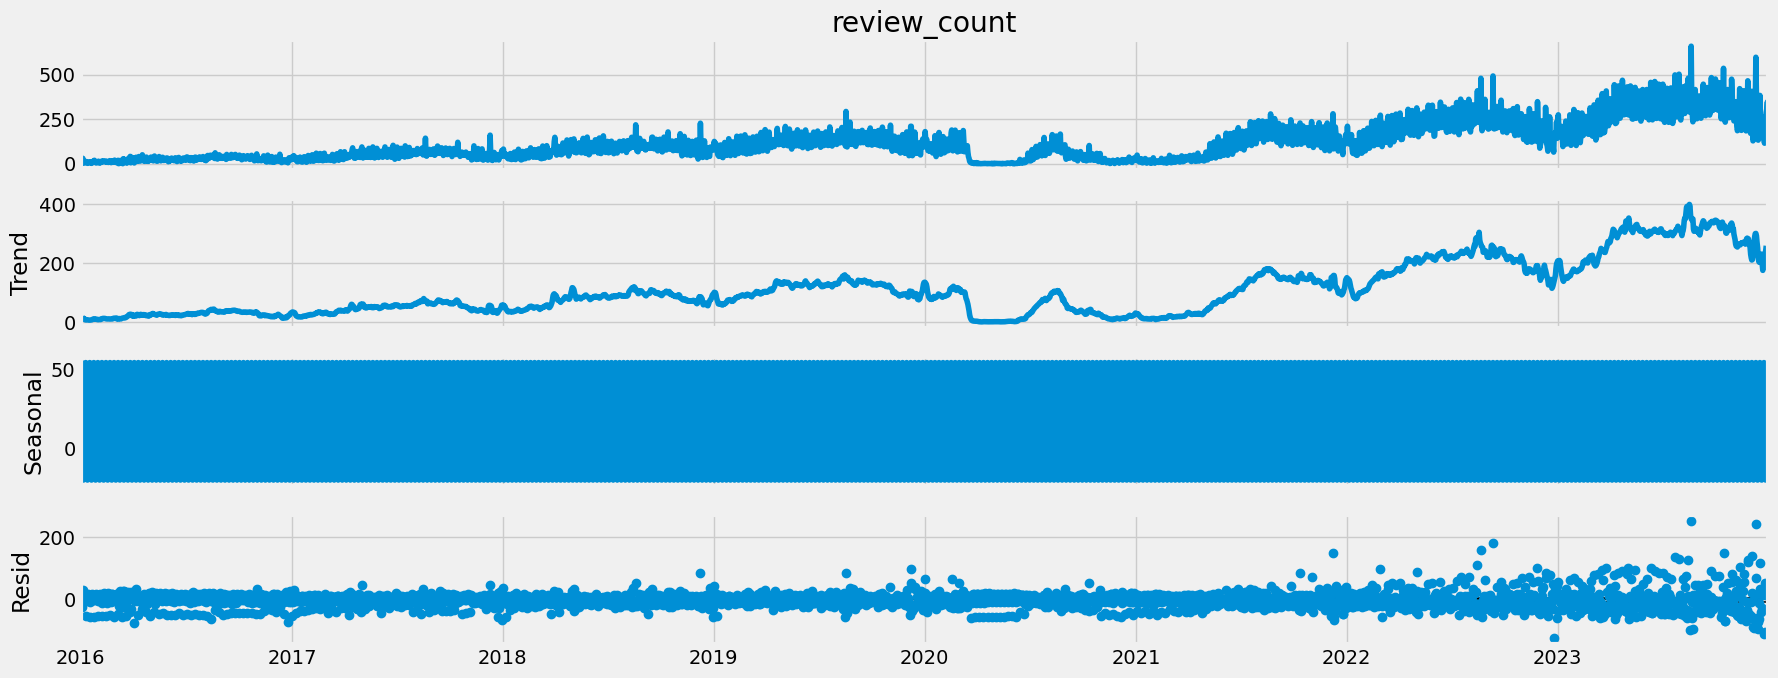

In [43]:
# Plot the separate components

decomposition.plot()
plt.show()

### *Observations*: Despite setting a daily frequency, it is possible that the decomposition method did not adequately capture the seasonal patterns.

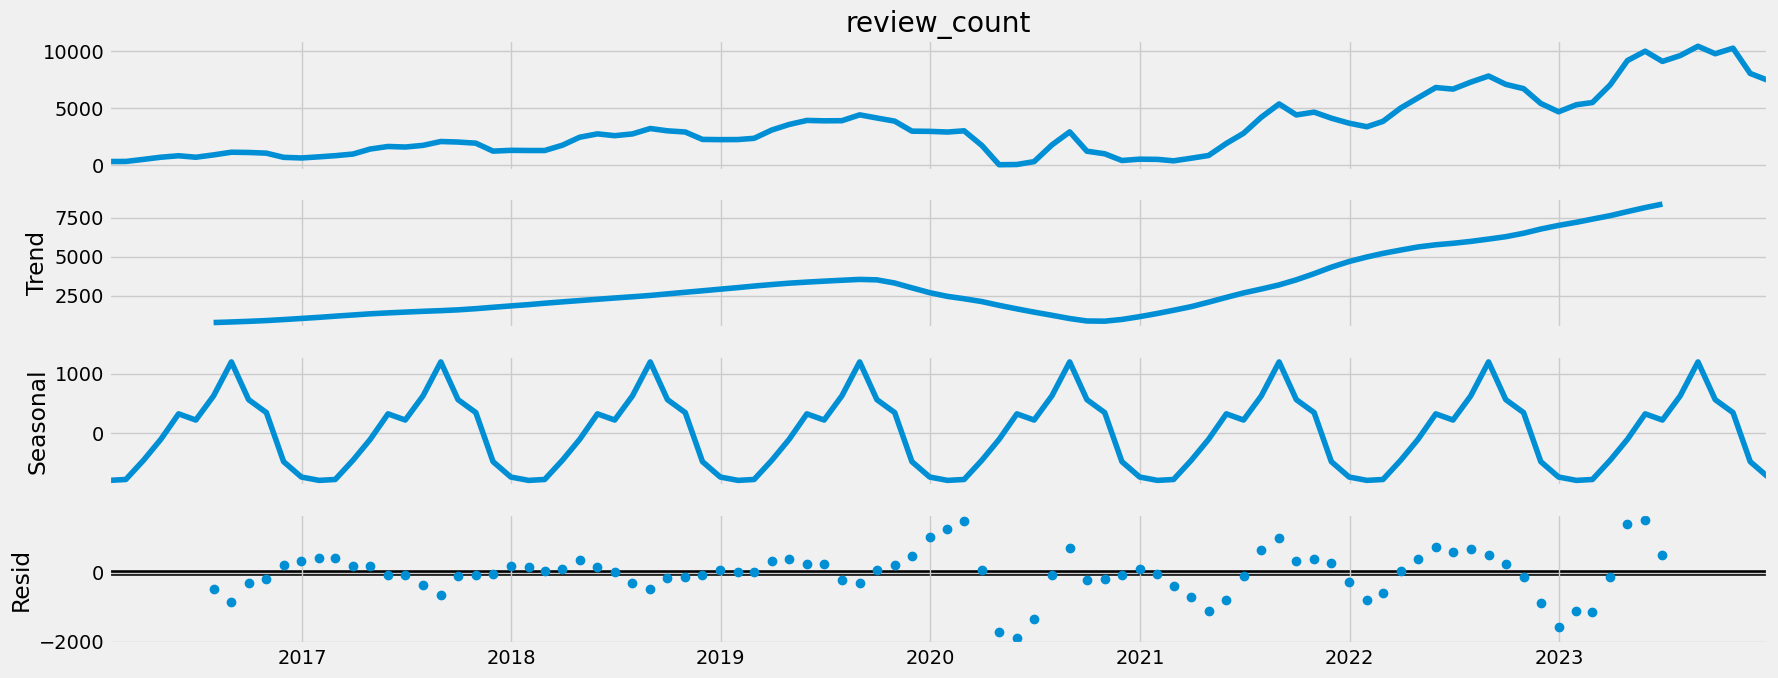

In [46]:
# Adjust the frequency of the datetime index to monthly
reviews_per_day_subset_monthly = reviews_per_day_subset.resample('M').sum()

# Decompose the time series using an additive model with the new frequency
decomposition_monthly = sm.tsa.seasonal_decompose(reviews_per_day_subset_monthly['review_count'], model='additive')

# Plot the decomposed components
decomposition_monthly.plot()
plt.show()

### *Observations*: By adjusting the frequency to monthly, we can clearly see an annual seasonal component. The trend shows sustained growth, except for the pandemic period.

## 6. Conduct a Dickey-Fuller test to check for stationarity.

    Interpret the results in a markdown cell and reference your null hypothesis.

In [54]:
from statsmodels.tsa.stattools import adfuller

# Define the function to print the correct output from the Dickey-Fuller test
def dickey_fuller(timeseries):   
    # Perform the Dickey-Fuller test
    print('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic', 'p-value', 'Number of Lags Used', 'Number of Observations Used'])
    for key, value in test[4].items():
        result['Critical Value (%s)' % key] = value
    print(result)

# Apply the test using the function on the time series
dickey_fuller(reviews_per_day_subset_monthly['review_count'])

Dickey-Fuller Stationarity test:
Test Statistic                 -0.744550
p-value                         0.834870
Number of Lags Used            12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


### *Observations*:
### The Dickey-Fuller test that we conducted shows that we cannot reject the null hypothesis that the series is non-stationary.
### The Critical Value (10%) is -2.585713, which is bigger than the Test Statistic of -0.744550.
### Also, the p-value of 0.834870 indicates that the test result is not significant.

## 7. If your data isn’t stationary, conduct a round of differencing on it and repeat step 6.

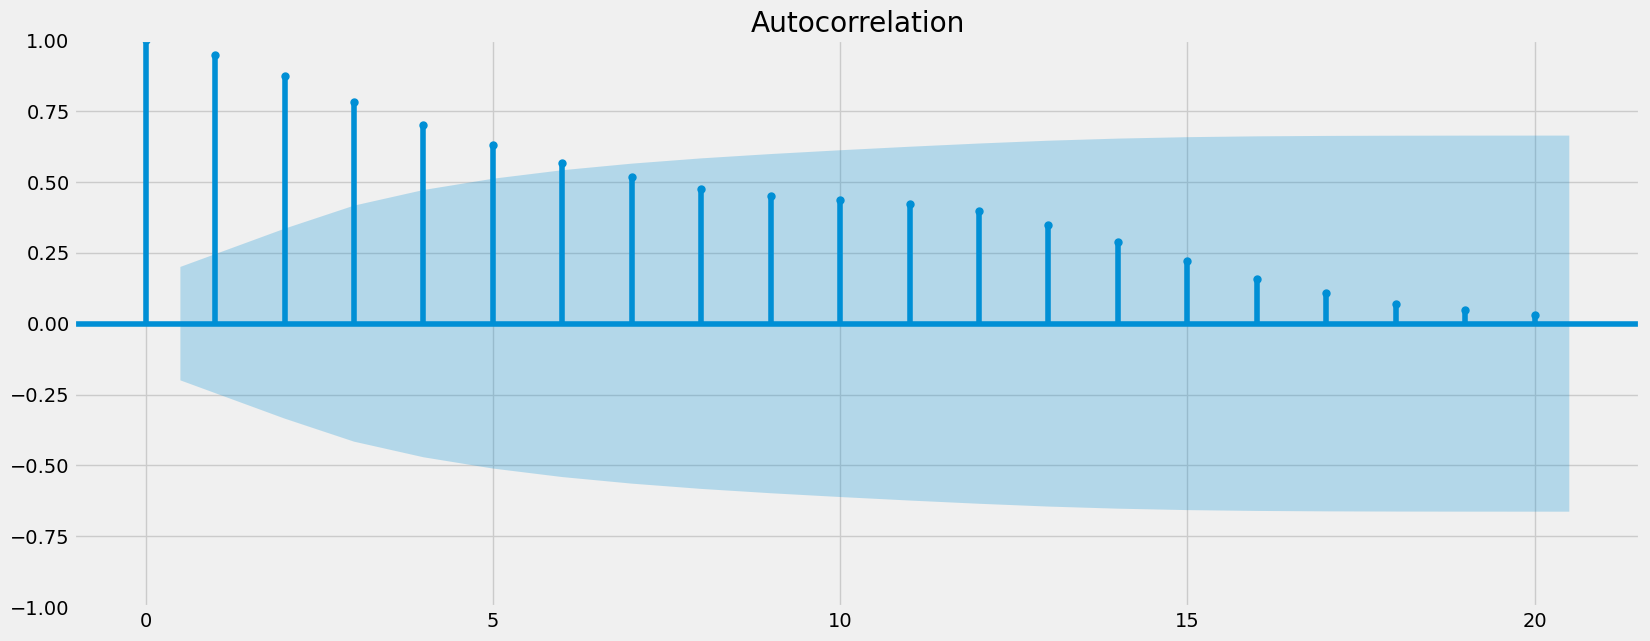

In [60]:
# Before differencing on it, let´s check out the autocorrelations

# Import the autocorrelation and partial correlation plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot the autocorrelation function (ACF)
plot_acf(reviews_per_day_subset_monthly['review_count'])
plt.show()

In [62]:
# Perform differencing to make the series stationary
reviews_diff = reviews_per_day_subset_monthly['review_count'] - reviews_per_day_subset_monthly['review_count'].shift(1)

# Drop the NaN values created by the differencing
reviews_diff.dropna(inplace=True)

In [68]:
reviews_diff.head()

date
2016-02-29      5.0
2016-03-31    184.0
2016-04-30    187.0
2016-05-31    129.0
2016-06-30   -130.0
Freq: ME, Name: review_count, dtype: float64

In [74]:
type(reviews_diff)

pandas.core.series.Series

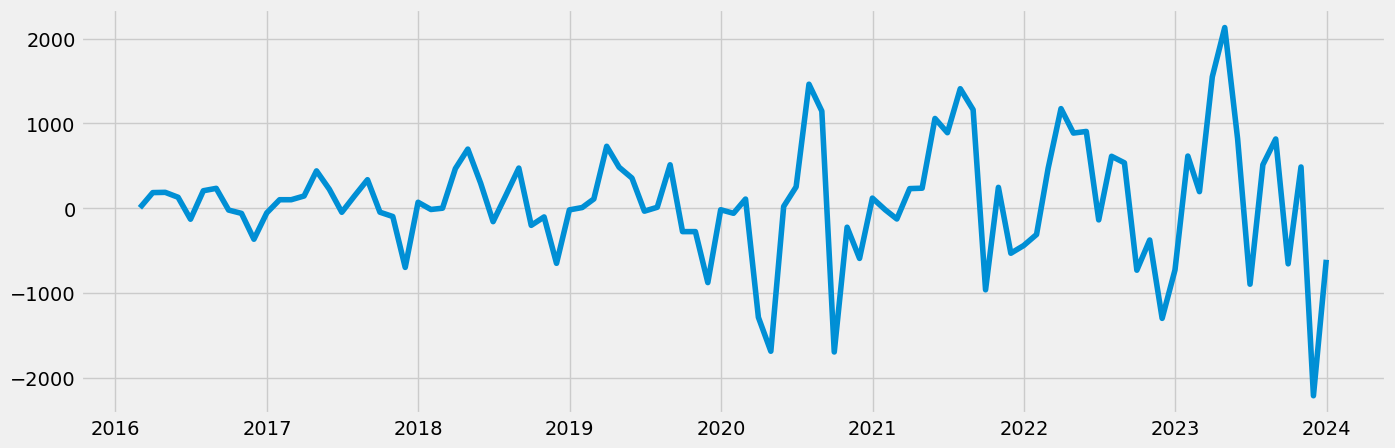

In [76]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(reviews_diff)
plt.show()


In [78]:
# Run the Dickey-Fuller test again on the differenced series

dickey_fuller(reviews_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -1.903569
p-value                         0.330384
Number of Lags Used            12.000000
Number of Observations Used    82.000000
Critical Value (1%)            -3.512738
Critical Value (5%)            -2.897490
Critical Value (10%)           -2.585949
dtype: float64


### *Observations*:
### Despite the differencing, the series is still non-stationary. The test statistic and p-value have decreased, indicating progress towards stationarity, but we still cannot reject the null hypothesis.

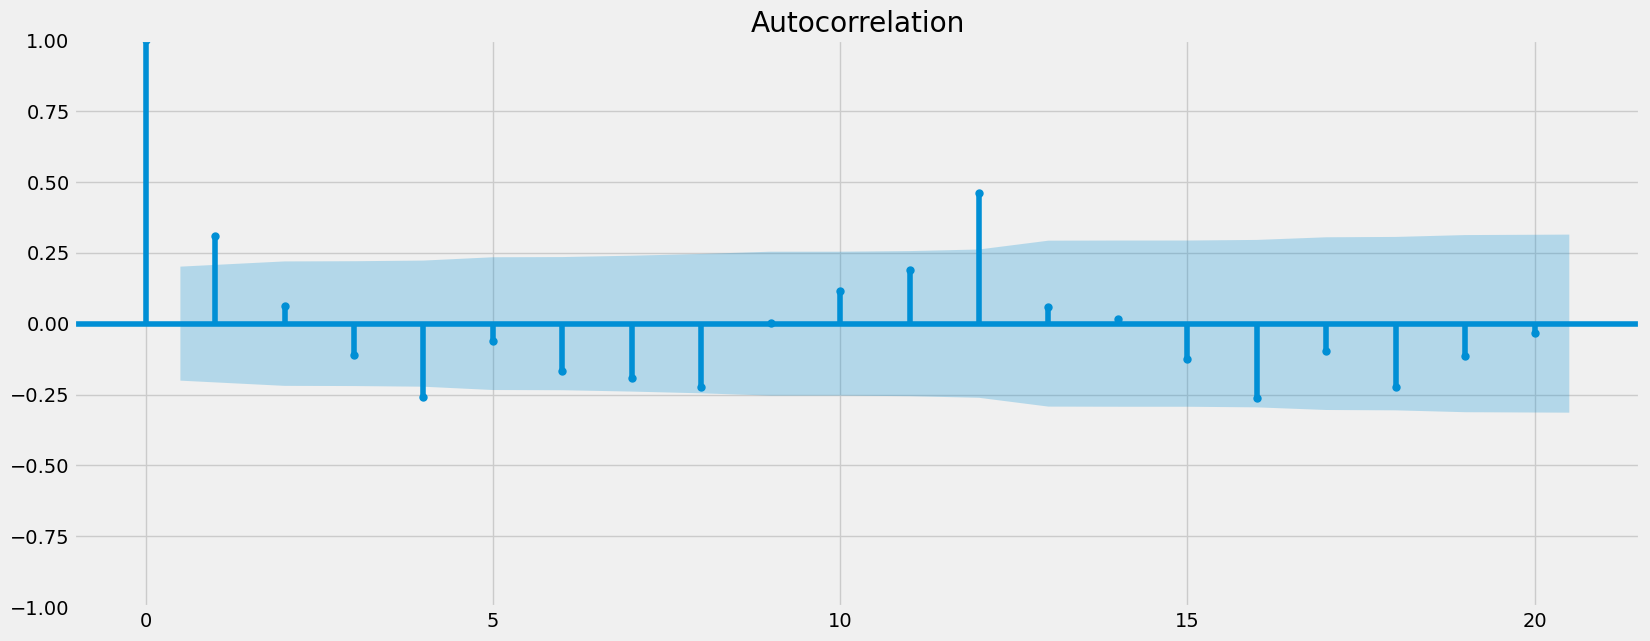

In [81]:
# Plot the autocorrelation function (ACF) for the differenced series

plot_acf(reviews_diff)
plt.show()

### *Observations*:
### The series has approached stationarity as suggested by the drop in the initial lags, but the peak at lag 12 indicates that there are still patterns that need to be modeled.

## 8. If your data still isn’t stationary, perform another round of differencing and repeat step 6.

In [87]:
# Perform second differencing to make the series stationary
reviews_diff2 = reviews_diff - reviews_diff.shift(1)

# Drop the NaN values created by the second differencing
reviews_diff2.dropna(inplace=True)

In [91]:
reviews_diff2.head()

date
2016-03-31    179.0
2016-04-30      3.0
2016-05-31    -58.0
2016-06-30   -259.0
2016-07-31    336.0
Freq: ME, Name: review_count, dtype: float64

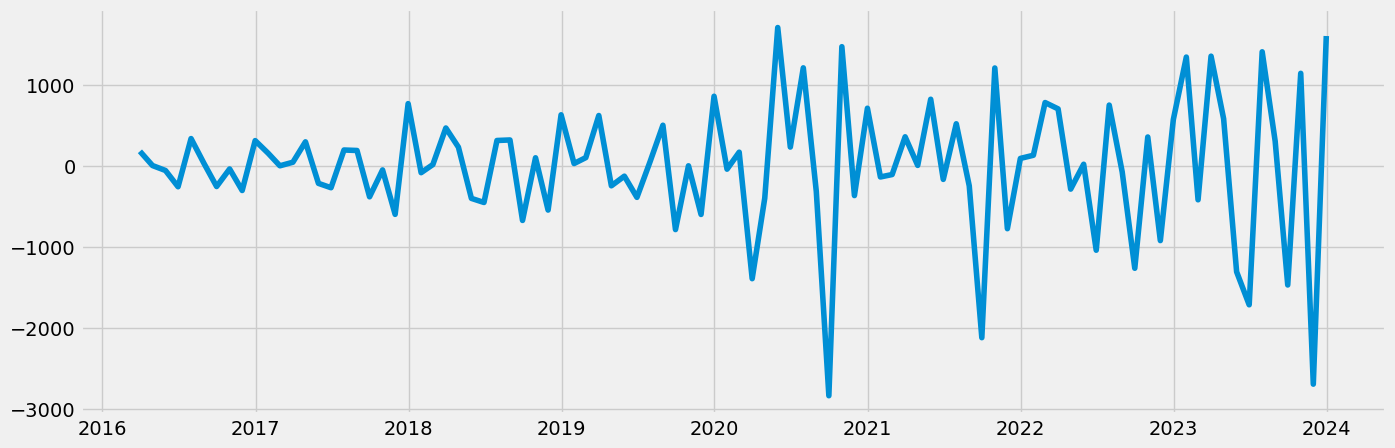

In [93]:
# Check out what the second differencing did to the time-series curve

plt.figure(figsize=(15, 5), dpi=100)
plt.plot(reviews_diff2)
plt.show()

In [95]:
# Run the Dickey-Fuller test again on the twice differenced series

dickey_fuller(reviews_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.915429
p-value                         0.000033
Number of Lags Used            12.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64


### *Observations*:
### After the second differencing, the time series has achieved stationarity.
### The test statistic value (-4.915429) is lower than all the critical values (at 1%, 5%, and 10%).
### The p-value (0.000033) is very small, indicating that we can reject the null hypothesis of non-stationarity with a high level of confidence.

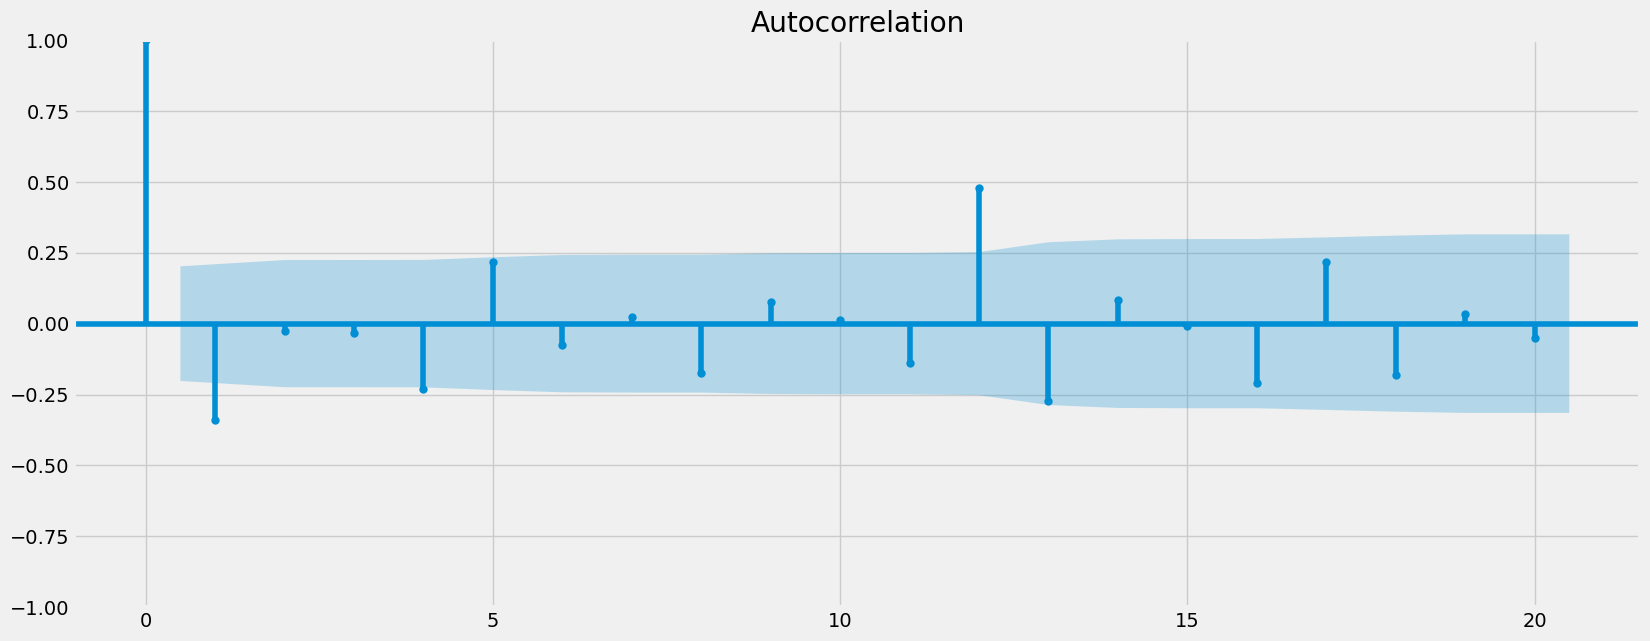

In [100]:
# Plot the autocorrelation function (ACF) for the twice differenced series

plot_acf(reviews_diff2)
plt.show()

### The rapid drop in autocorrelation suggests that stationarity has been achieved. The remaining significant lags could be addressed in subsequent models such as ARIMA.